In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_cust = pd.read_csv('customers.csv',  low_memory=False)
df_ordr = pd.read_csv('orders.csv',  low_memory=False)
df_odit = pd.read_csv('orders_items.csv',  low_memory=False)
df_prod = pd.read_csv('products.csv',  low_memory=False)
df_traf = pd.read_csv('traffic.csv',  low_memory=False)

# Data has been preprocessed in excel

In [3]:
dataframes = [df_cust,df_ordr,df_odit,df_prod,df_traf]

for df in dataframes:
    print(df.info(null_counts = True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44661 entries, 0 to 44660
Data columns (total 3 columns):
cust_id      44661 non-null float64
full_name    33699 non-null object
cust_date    44661 non-null object
dtypes: float64(1), object(2)
memory usage: 1.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21358 entries, 0 to 21357
Data columns (total 14 columns):
order_id                  21358 non-null float64
order_date                21358 non-null object
close_date                20195 non-null object
cancel_date               410 non-null object
cust_id                   21358 non-null float64
financial_status          21358 non-null object
fulfillment_status        20680 non-null object
process_date              21358 non-null object
total_price               21358 non-null float64
shipping_rate             21358 non-null float64
subtotal_price            21358 non-null float64
total_discounts           21358 non-null float64
total_line_items_price    21358 non-null

## Explore Sample Size

In [4]:
len(df_cust['cust_id'].drop_duplicates())
# Number of unique customer ID

41596

In [5]:
len(df_ordr['order_id'].drop_duplicates())
# Number of unique order ID

4219

In [6]:
df_ordr['order_success'].sum() / len(df_ordr['order_success'])
# 83.56% orders were successful, not canceled, refunded, or pending based on financial status

0.835565127820957

In [7]:
len(df_prod['product_id'].drop_duplicates())
# Number of unique product ID

46

In [8]:
len(df_prod['title'].drop_duplicates())
# Number of unique product title

234

In [9]:
len(df_prod['product_type'].drop_duplicates())
# Number of unique product type

29

In [10]:
len(df_traf['date_day'].drop_duplicates())
# Days of traffic record

579

In [11]:
# Number of unique rows in each dataframe
for df in dataframes:
    temp = df.drop_duplicates()
    print(len(temp.index))

# No duplicate in traffic records
# Use unique cust ID as number of customers
# Need to further explore number of orders

44484
20679
27736
246
579


In [12]:
cust_total = 41596
cust_order = len(df_ordr['cust_id'].drop_duplicates())
cust_ratio = cust_order / cust_total

print(cust_order,cust_ratio)
# Only 12% registered customers have made orders

4998 0.1201557842100202


In [13]:
len(df_ordr['order_id'].drop_duplicates(keep = False))
# There are 2295 order IDs without any duplicate, out of total 4000 unique IDs

3668

In [14]:
len(df_ordr[['order_id','cust_id']].drop_duplicates().index)
# This indicates one order ID is connect to multiple customers, which should be impossible
# Hence, duplicates of order IDs is likely to be caused by recording error, meaning some different IDs are recorded as the same

12664

In [15]:
idlist_uni = df_ordr['order_id'].drop_duplicates(keep = False)
idlist_uni = pd.DataFrame(idlist_uni)

test = idlist_uni.merge(df_ordr, how = 'inner', on = 'order_id')
print(len(test.index),len(test[['order_id','cust_id']].drop_duplicates().index))
# This further proves that there's no "multi customers issue" for those 2295 no-duplicate order IDs

3668 3668


In [16]:
print(len(df_odit[['order_id']].drop_duplicates()),len(df_odit[['order_id']].drop_duplicates(keep = False)))
# Number of unique IDs matche between the 2 table, but more with duplicates in oredrs_items table
# This is as expected, since there might be multiple items in an unique order

4219 2295


In [17]:
df_odit['line_items_price'] = df_odit['price'] * df_odit['quantity']

price_odit = df_odit['line_items_price'].sum()
price_ordr = df_ordr['total_line_items_price'].sum()

print(price_odit,price_ordr)
# Subtotal in the 2 tables are very close, that in orders_items is a little bit higher
# Hence I assume there's no actual duplicate records in orders table, only error order IDs

1596690.49 1596546.4900000002


## Assign New Order ID For Duplicates

In [18]:
idlist_all = list(df_ordr['order_id'].drop_duplicates())
len(idlist_all)

4219

In [19]:
idlist_uni = list(df_ordr['order_id'].drop_duplicates(keep = False))
len(idlist_uni)

3668

In [20]:
idlist_dup = set(idlist_all) - set(idlist_uni)
idlist_dup = list(idlist_dup)
len(idlist_dup)

551

### Fix Orders Table

In [21]:
data1 = df_ordr[df_ordr['order_id'].isin(idlist_dup)]
len(data1.index)

17690

In [22]:
data2 = df_ordr[df_ordr['order_id'].isin(idlist_uni)]
len(data2.index)

3668

In [23]:
min(idlist_uni)

7675398239.0

In [24]:
data1['old_index'] = data1.index

data1 = data1.sort_values(['order_id','old_index']).reset_index(drop = True)
data1[:5]

C:\Users\STU\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,order_id,order_date,close_date,cancel_date,cust_id,financial_status,fulfillment_status,process_date,total_price,shipping_rate,subtotal_price,total_discounts,total_line_items_price,order_success,old_index
0,1.110000e+11,2016/10/26,2016/10/27,NaN,1.710000e+11,paid,fulfilled,2016/10/26,132.87,52.87,80.0,0.0,80.0,1,3640
1,1.110000e+11,2016/10/26,2016/10/27,NaN,1.710000e+11,paid,fulfilled,2016/10/26,52.00,7.00,45.0,0.0,45.0,1,3641
2,1.110000e+11,2016/10/27,2016/10/27,NaN,1.710000e+11,paid,fulfilled,2016/10/27,42.00,7.00,35.0,0.0,35.0,1,3642
3,1.110000e+11,2016/10/27,2016/10/27,NaN,1.710000e+11,paid,fulfilled,2016/10/27,52.00,7.00,45.0,0.0,45.0,1,3643
4,1.110000e+11,2016/10/27,2016/10/27,NaN,8.703040e+09,paid,fulfilled,2016/10/27,52.00,7.00,45.0,0.0,45.0,1,3644


In [25]:
# Assign new order id in orders table
data1['new_id'] = range(1,17691)
len(data1.index)

17690

In [26]:
data2['old_index'] = data2.index
data2['new_id'] = data2['order_id']
len(data2.index)

C:\Users\STU\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\STU\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


3668

In [27]:
data1[:5]

,order_id,order_date,close_date,cancel_date,cust_id,financial_status,fulfillment_status,process_date,total_price,shipping_rate,subtotal_price,total_discounts,total_line_items_price,order_success,old_index,new_id
0,1.110000e+11,2016/10/26,2016/10/27,NaN,1.710000e+11,paid,fulfilled,2016/10/26,132.87,52.87,80.0,0.0,80.0,1,3640,1
1,1.110000e+11,2016/10/26,2016/10/27,NaN,1.710000e+11,paid,fulfilled,2016/10/26,52.00,7.00,45.0,0.0,45.0,1,3641,2
2,1.110000e+11,2016/10/27,2016/10/27,NaN,1.710000e+11,paid,fulfilled,2016/10/27,42.00,7.00,35.0,0.0,35.0,1,3642,3
3,1.110000e+11,2016/10/27,2016/10/27,NaN,1.710000e+11,paid,fulfilled,2016/10/27,52.00,7.00,45.0,0.0,45.0,1,3643,4
4,1.110000e+11,2016/10/27,2016/10/27,NaN,8.703040e+09,paid,fulfilled,2016/10/27,52.00,7.00,45.0,0.0,45.0,1,3644,5


In [28]:
data1[-5:]

,order_id,order_date,close_date,cancel_date,cust_id,financial_status,fulfillment_status,process_date,total_price,shipping_rate,subtotal_price,total_discounts,total_line_items_price,order_success,old_index,new_id
17685,9.400000e+11,2018/3/21,NaN,NaN,1.060000e+12,paid,NaN,2018/3/21,98.55,0.0,90.0,10.0,100.0,1,21353,17686
17686,9.400000e+11,2018/3/21,NaN,NaN,8.300000e+11,paid,NaN,2018/3/21,53.66,0.0,49.0,49.0,98.0,1,21354,17687
17687,9.400000e+11,2018/3/21,NaN,NaN,1.060000e+12,paid,NaN,2018/3/21,100.00,0.0,100.0,0.0,100.0,1,21355,17688
17688,9.400000e+11,2018/3/21,NaN,NaN,1.060000e+12,paid,NaN,2018/3/21,189.44,0.0,173.0,0.0,173.0,1,21356,17689
17689,9.400000e+11,2018/3/22,NaN,NaN,6.600000e+11,paid,NaN,2018/3/22,404.00,0.0,404.0,0.0,404.0,1,21357,17690


In [29]:
data_order = pd.concat([data1,data2], axis = 0)
data_order = data_order.reset_index(drop = True)
len(data_order.index)

21358

In [30]:
data_order[:5]

,order_id,order_date,close_date,cancel_date,cust_id,financial_status,fulfillment_status,process_date,total_price,shipping_rate,subtotal_price,total_discounts,total_line_items_price,order_success,old_index,new_id
0,1.110000e+11,2016/10/26,2016/10/27,NaN,1.710000e+11,paid,fulfilled,2016/10/26,132.87,52.87,80.0,0.0,80.0,1,3640,1.0
1,1.110000e+11,2016/10/26,2016/10/27,NaN,1.710000e+11,paid,fulfilled,2016/10/26,52.00,7.00,45.0,0.0,45.0,1,3641,2.0
2,1.110000e+11,2016/10/27,2016/10/27,NaN,1.710000e+11,paid,fulfilled,2016/10/27,42.00,7.00,35.0,0.0,35.0,1,3642,3.0
3,1.110000e+11,2016/10/27,2016/10/27,NaN,1.710000e+11,paid,fulfilled,2016/10/27,52.00,7.00,45.0,0.0,45.0,1,3643,4.0
4,1.110000e+11,2016/10/27,2016/10/27,NaN,8.703040e+09,paid,fulfilled,2016/10/27,52.00,7.00,45.0,0.0,45.0,1,3644,5.0


In [31]:
data_order[-5:]

,order_id,order_date,close_date,cancel_date,cust_id,financial_status,fulfillment_status,process_date,total_price,shipping_rate,subtotal_price,total_discounts,total_line_items_price,order_success,old_index,new_id
21353,6.820000e+11,2017/9/26,2017/9/26,NaN,7.590000e+11,partially_refunded,fulfilled,2017/9/26,63.94,7.0,52.0,0.0,52.0,0,17071,6.820000e+11
21354,6.860000e+11,2017/9/26,2017/10/11,NaN,3.810000e+11,paid,fulfilled,2017/9/26,0.00,0.0,0.0,31.5,31.5,1,17072,6.860000e+11
21355,6.980000e+11,2017/9/26,2017/9/27,NaN,7.600000e+11,partially_refunded,fulfilled,2017/9/26,93.00,7.0,86.0,0.0,86.0,0,17073,6.980000e+11
21356,8.440000e+11,2017/12/31,2018/1/11,NaN,6.460000e+11,paid,fulfilled,2017/12/31,95.60,20.0,75.6,8.4,84.0,1,19340,8.440000e+11
21357,9.010000e+11,2018/2/21,2018/2/22,NaN,8.689282e+09,paid,fulfilled,2018/2/21,13.00,0.0,13.0,25.0,38.0,1,20337,9.010000e+11


### Fix Orders_Items Table

In [32]:
data3 = df_odit[df_odit['order_id'].isin(idlist_dup)]
len(data3.index)

30964

In [33]:
data4 = df_odit[df_odit['order_id'].isin(idlist_uni)]
len(data4.index)

5862

In [34]:
data3['old_index'] = data3.index

data3 = data3.sort_values(['record_id','order_id','old_index']).reset_index(drop = True)
data3[:5]

C:\Users\STU\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,record_id,order_id,product_id,product_style,variant_id,sku,product_title,fulfillment_status,price,quantity,order_success,product_type,line_items_price,old_index
0,9.731222e+10,1.110000e+11,1.292763e+10,2c259a42d38f5f097274beff811168e2,5.054706e+10,549684602f6a1e779751c80445d819fc,5cfd6c4e00b25e6dec5538928206b7b8,fulfilled,35.0,1,1,Shirts,35.0,5323
1,9.731225e+10,1.110000e+11,1.292763e+10,6056dc7fb0e6987bfb6d08a8a707446f,5.054714e+10,aaafd50739d858e6eac21bb5be9b994b,d57bc87aca919b4758da6974cdf607fa,fulfilled,45.0,1,1,Crop Top,45.0,13865
2,9.731336e+10,1.110000e+11,1.292763e+10,6056dc7fb0e6987bfb6d08a8a707446f,5.054714e+10,71bf67b39ac91f0b12b7ec1b105f9427,d57bc87aca919b4758da6974cdf607fa,fulfilled,45.0,1,1,Crop Top,45.0,5324
3,9.740521e+10,1.110000e+11,1.292763e+10,2c259a42d38f5f097274beff811168e2,5.054706e+10,f9be438e2dbfe8b183c5c6dad11c0423,5cfd6c4e00b25e6dec5538928206b7b8,fulfilled,35.0,1,1,Shirts,35.0,5325
4,9.740810e+10,1.110000e+11,1.292763e+10,6056dc7fb0e6987bfb6d08a8a707446f,5.054714e+10,71bf67b39ac91f0b12b7ec1b105f9427,d57bc87aca919b4758da6974cdf607fa,fulfilled,45.0,1,1,Crop Top,45.0,5326


In [35]:
data3[-5:]

,record_id,order_id,product_id,product_style,variant_id,sku,product_title,fulfillment_status,price,quantity,order_success,product_type,line_items_price,old_index
30959,2.250000e+12,9.400000e+11,1.180000e+12,af17bc19b43df4495c26fd5a403c9361,1.050000e+13,21fca0d6ab46ac4d7b93a7ca15527276,84155b7b86bcc4d0dd3438dda3e544e2,NaN,100.0,1,1,Mini,100.0,36704
30960,2.250000e+12,9.400000e+11,1.180000e+12,2a9131f81f9e29d64ed63ff692d751af,1.050000e+13,021e6f12f1f78944248d9ebfe9cbf553,66af53bd68b9939f8e6255f1705c3d68,NaN,62.0,1,1,Trousers,62.0,36773
30961,2.250000e+12,9.400000e+11,1.180000e+12,87fe39e585e64ca63d7e02a88adbbdc7,1.050000e+13,fed78502b587afd7f154f964262af915,745e43480b46b959a73fa1f6989e5a25,NaN,98.0,1,1,Trousers,98.0,36802
30962,2.250000e+12,9.400000e+11,1.180000e+12,07859c3950cffd3e7535c999cc6f5ea1,1.050000e+13,faa2118bc428af672a82b0b3e1e64e75,d7df22ca607209fbfd69f7599a572934,NaN,65.0,1,1,Pants,65.0,36816
30963,2.250000e+12,9.400000e+11,1.180000e+12,35e3c55735143f88cb170d44b6f5ef0d,1.050000e+13,b6304d1a4b80b1fab5ad05f8ae17245c,b045ebe06ca6c1c02be45eb848424ba0,NaN,79.0,1,1,Sweater,79.0,36822


In [36]:
idx = 1
sub = 0
for i in data3.index:
    sub += data3.loc[i,'line_items_price']
    if idx <= 17690:
        data3.loc[i,'new_id'] = idx
        if  sub >= data1.loc[idx-1,'total_line_items_price'] - 30.5:
            idx += 1
            sub =  0   
    else:
        data3.loc[i,'new_id'] = 17690

In [37]:
data3[:5]

,record_id,order_id,product_id,product_style,variant_id,sku,product_title,fulfillment_status,price,quantity,order_success,product_type,line_items_price,old_index,new_id
0,9.731222e+10,1.110000e+11,1.292763e+10,2c259a42d38f5f097274beff811168e2,5.054706e+10,549684602f6a1e779751c80445d819fc,5cfd6c4e00b25e6dec5538928206b7b8,fulfilled,35.0,1,1,Shirts,35.0,5323,1.0
1,9.731225e+10,1.110000e+11,1.292763e+10,6056dc7fb0e6987bfb6d08a8a707446f,5.054714e+10,aaafd50739d858e6eac21bb5be9b994b,d57bc87aca919b4758da6974cdf607fa,fulfilled,45.0,1,1,Crop Top,45.0,13865,1.0
2,9.731336e+10,1.110000e+11,1.292763e+10,6056dc7fb0e6987bfb6d08a8a707446f,5.054714e+10,71bf67b39ac91f0b12b7ec1b105f9427,d57bc87aca919b4758da6974cdf607fa,fulfilled,45.0,1,1,Crop Top,45.0,5324,2.0
3,9.740521e+10,1.110000e+11,1.292763e+10,2c259a42d38f5f097274beff811168e2,5.054706e+10,f9be438e2dbfe8b183c5c6dad11c0423,5cfd6c4e00b25e6dec5538928206b7b8,fulfilled,35.0,1,1,Shirts,35.0,5325,3.0
4,9.740810e+10,1.110000e+11,1.292763e+10,6056dc7fb0e6987bfb6d08a8a707446f,5.054714e+10,71bf67b39ac91f0b12b7ec1b105f9427,d57bc87aca919b4758da6974cdf607fa,fulfilled,45.0,1,1,Crop Top,45.0,5326,4.0


In [38]:
data3[-5:]

,record_id,order_id,product_id,product_style,variant_id,sku,product_title,fulfillment_status,price,quantity,order_success,product_type,line_items_price,old_index,new_id
30959,2.250000e+12,9.400000e+11,1.180000e+12,af17bc19b43df4495c26fd5a403c9361,1.050000e+13,21fca0d6ab46ac4d7b93a7ca15527276,84155b7b86bcc4d0dd3438dda3e544e2,NaN,100.0,1,1,Mini,100.0,36704,17690.0
30960,2.250000e+12,9.400000e+11,1.180000e+12,2a9131f81f9e29d64ed63ff692d751af,1.050000e+13,021e6f12f1f78944248d9ebfe9cbf553,66af53bd68b9939f8e6255f1705c3d68,NaN,62.0,1,1,Trousers,62.0,36773,17690.0
30961,2.250000e+12,9.400000e+11,1.180000e+12,87fe39e585e64ca63d7e02a88adbbdc7,1.050000e+13,fed78502b587afd7f154f964262af915,745e43480b46b959a73fa1f6989e5a25,NaN,98.0,1,1,Trousers,98.0,36802,17690.0
30962,2.250000e+12,9.400000e+11,1.180000e+12,07859c3950cffd3e7535c999cc6f5ea1,1.050000e+13,faa2118bc428af672a82b0b3e1e64e75,d7df22ca607209fbfd69f7599a572934,NaN,65.0,1,1,Pants,65.0,36816,17690.0
30963,2.250000e+12,9.400000e+11,1.180000e+12,35e3c55735143f88cb170d44b6f5ef0d,1.050000e+13,b6304d1a4b80b1fab5ad05f8ae17245c,b045ebe06ca6c1c02be45eb848424ba0,NaN,79.0,1,1,Sweater,79.0,36822,17690.0


In [39]:
data4['old_index'] = data4.index
data4['new_id'] = data4['order_id']
len(data4.index)

C:\Users\STU\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\STU\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


5862

In [40]:
data_odrit = pd.concat([data3,data4], axis = 0)
data_odrit = data_odrit.reset_index(drop = True)
len(data_odrit.index)

36826

In [41]:
# Re-assign order_success column
data_odrit = data_odrit.drop(['order_success'], axis = 'columns')
data_odrit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36826 entries, 0 to 36825
Data columns (total 14 columns):
record_id             36826 non-null float64
order_id              36826 non-null float64
product_id            36802 non-null float64
product_style         36826 non-null object
variant_id            36826 non-null float64
sku                   36826 non-null object
product_title         36826 non-null object
fulfillment_status    35257 non-null object
price                 36826 non-null float64
quantity              36826 non-null int64
product_type          36826 non-null object
line_items_price      36826 non-null float64
old_index             36826 non-null int64
new_id                36826 non-null float64
dtypes: float64(7), int64(2), object(5)
memory usage: 3.9+ MB


In [42]:
data_odrit = data_odrit.merge(data_order[['new_id','order_success']], how = 'inner', on = 'new_id')

data_odrit[['new_id','order_success']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36826 entries, 0 to 36825
Data columns (total 2 columns):
new_id           36826 non-null float64
order_success    36826 non-null int64
dtypes: float64(1), int64(1)
memory usage: 863.1 KB


In [43]:
data_odrit.head()

,record_id,order_id,product_id,product_style,variant_id,sku,product_title,fulfillment_status,price,quantity,product_type,line_items_price,old_index,new_id,order_success
0,9.731222e+10,1.110000e+11,1.292763e+10,2c259a42d38f5f097274beff811168e2,5.054706e+10,549684602f6a1e779751c80445d819fc,5cfd6c4e00b25e6dec5538928206b7b8,fulfilled,35.0,1,Shirts,35.0,5323,1.0,1
1,9.731225e+10,1.110000e+11,1.292763e+10,6056dc7fb0e6987bfb6d08a8a707446f,5.054714e+10,aaafd50739d858e6eac21bb5be9b994b,d57bc87aca919b4758da6974cdf607fa,fulfilled,45.0,1,Crop Top,45.0,13865,1.0,1
2,9.731336e+10,1.110000e+11,1.292763e+10,6056dc7fb0e6987bfb6d08a8a707446f,5.054714e+10,71bf67b39ac91f0b12b7ec1b105f9427,d57bc87aca919b4758da6974cdf607fa,fulfilled,45.0,1,Crop Top,45.0,5324,2.0,1
3,9.740521e+10,1.110000e+11,1.292763e+10,2c259a42d38f5f097274beff811168e2,5.054706e+10,f9be438e2dbfe8b183c5c6dad11c0423,5cfd6c4e00b25e6dec5538928206b7b8,fulfilled,35.0,1,Shirts,35.0,5325,3.0,1
4,9.740810e+10,1.110000e+11,1.292763e+10,6056dc7fb0e6987bfb6d08a8a707446f,5.054714e+10,71bf67b39ac91f0b12b7ec1b105f9427,d57bc87aca919b4758da6974cdf607fa,fulfilled,45.0,1,Crop Top,45.0,5326,4.0,1


## 1. How Traffic Affects Orders

### Explore Dates

In [44]:
df_traf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 8 columns):
index                    579 non-null int64
date_day                 579 non-null object
page_views               579 non-null int64
sessions                 579 non-null int64
product_detail_views     579 non-null int64
product_checkouts        579 non-null int64
product_adds_to_carts    579 non-null int64
avg_session_duration     579 non-null float64
dtypes: float64(1), int64(6), object(1)
memory usage: 36.3+ KB


In [45]:
df_traf[:5]

,index,date_day,page_views,sessions,product_detail_views,product_checkouts,product_adds_to_carts,avg_session_duration
0,0,2016/8/17,204,6,0,0,0,2374.166667
1,1,2016/8/18,661,27,0,0,0,1632.111111
2,2,2016/8/19,241,12,0,0,0,1891.250000
3,3,2016/8/20,534,23,0,0,0,1557.956522
4,4,2016/8/21,10276,4946,0,0,0,73.470481


In [46]:
df_traf['date_day'] = pd.to_datetime(df_traf['date_day'])

late_date_traffic = df_traf['date_day'].max()
earl_date_traffic = df_traf['date_day'].min()

print(earl_date_traffic, late_date_traffic, (late_date_traffic - earl_date_traffic).days)

2016-08-17 00:00:00 2018-03-18 00:00:00 578


In [47]:
data_order['order_date'] = pd.to_datetime(data_order['order_date'])

late_date_order = data_order['order_date'].max()
earl_date_order = data_order['order_date'].min()

print(earl_date_order, late_date_order, (late_date_order - earl_date_order).days)

2016-08-21 00:00:00 2018-03-22 00:00:00 578


It is seen that total numbers of days on record are the same in the 2 tables, but the first and last day in Orders are both 4 days behind those in Traffic. There are also missing values for the first 5 days in Traffic table. 

Two solutions could be applied in this case: The 1st is to shift all dates in Orders table forward by 4 days, which will cause issues while comparing orders and traffic in the first 5 days; The 2nd is to abandon the 5 days, and start from 2016-08-22, which will lose the first day and last 4 days in Orders table.

Since in Orders table, there were around 1,000 orders in the first 5 days, but only 125 orders in the last 4 days and 1 order on 2016-08-22, less information will be lost using the 2nd solution.

In [48]:
import datetime as dt

late_date = late_date_traffic
earl_date = dt.datetime(2016,8,22)

print(earl_date, late_date, (late_date - earl_date).days)

2016-08-22 00:00:00 2018-03-18 00:00:00 573


In [49]:
order_inner = data_order[(data_order['order_date'] >= earl_date) & (data_order['order_date'] <= late_date)]

print(order_inner['order_date'].min(), order_inner['order_date'].max())

2016-08-22 00:00:00 2018-03-18 00:00:00


In [50]:
traffic = df_traf[df_traf['date_day'] >= earl_date]

print(traffic['date_day'].min(), traffic['date_day'].max())

2016-08-22 00:00:00 2018-03-18 00:00:00


### Merge Tables & Explore Features

In [51]:
order_groupbydate = order_inner.groupby('order_date').agg({'new_id': lambda x: len(x), 
                                                           'cust_id': lambda x: x.count(), 
                                                           'total_line_items_price': lambda x: x.sum(), 
                                                           'order_success': lambda x: x.sum()}).reset_index()
order_groupbydate.rename(columns={'new_id': 'order_count', 
                                  'order_date': 'date_day',
                                  'cust_id': 'cust_count', 
                                  'total_line_items_price': 'total_value'}, inplace=True)

order_groupbydate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 5 columns):
date_day         573 non-null datetime64[ns]
order_count      573 non-null float64
cust_count       573 non-null float64
total_value      573 non-null float64
order_success    573 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 22.5 KB


In [52]:
order_groupbydate.head()

,date_day,order_count,cust_count,total_value,order_success
0,2016-08-22,794.0,794.0,66550.0,661
1,2016-08-23,183.0,183.0,14701.0,154
2,2016-08-24,44.0,44.0,4057.0,31
3,2016-08-25,62.0,62.0,3564.0,47
4,2016-08-26,311.0,311.0,19969.0,248


In [53]:
traffic_order = traffic.merge(order_groupbydate, how = 'inner', on = 'date_day')

traffic_order.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 573 entries, 0 to 572
Data columns (total 12 columns):
index                    573 non-null int64
date_day                 573 non-null datetime64[ns]
page_views               573 non-null int64
sessions                 573 non-null int64
product_detail_views     573 non-null int64
product_checkouts        573 non-null int64
product_adds_to_carts    573 non-null int64
avg_session_duration     573 non-null float64
order_count              573 non-null float64
cust_count               573 non-null float64
total_value              573 non-null float64
order_success            573 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(7)
memory usage: 58.2 KB


In [54]:
traffic_order.head()

,index,date_day,page_views,sessions,product_detail_views,product_checkouts,product_adds_to_carts,avg_session_duration,order_count,cust_count,total_value,order_success
0,5,2016-08-22,625003,146860,175257,5639,10851,142.407837,794.0,794.0,66550.0,661
1,6,2016-08-23,220707,61654,58940,761,1817,106.161449,183.0,183.0,14701.0,154
2,7,2016-08-24,93694,27182,24935,256,638,98.999669,44.0,44.0,4057.0,31
3,8,2016-08-25,63927,15239,19167,901,1826,130.410854,62.0,62.0,3564.0,47
4,9,2016-08-26,55625,14209,16618,443,1225,117.764586,311.0,311.0,19969.0,248


In [55]:
# Create some KPIs
traffic_order['page_per_session'] = traffic_order['page_views'] / traffic_order['sessions']
traffic_order['conversion'] = traffic_order['order_count'] / traffic_order['sessions']
traffic_order['unit_per_order'] = traffic_order['product_checkouts'] / traffic_order['order_count']
traffic_order['order_per_cust'] = traffic_order['order_count'] / traffic_order['cust_count']
traffic_order['avg_order_value'] = traffic_order['total_value'] / traffic_order['order_count']
traffic_order['success_rate'] = traffic_order['order_success'] / traffic_order['order_count']

traffic_order = traffic_order.drop(['index'], axis = 'columns')
traffic_order[['page_per_session','conversion','unit_per_order','order_per_cust','avg_order_value','success_rate']].head()

,page_per_session,conversion,unit_per_order,order_per_cust,avg_order_value,success_rate
0,4.255774,0.005407,7.102015,1.0,83.816121,0.832494
1,3.579768,0.002968,4.158470,1.0,80.333333,0.841530
2,3.446913,0.001619,5.818182,1.0,92.204545,0.704545
3,4.194960,0.004069,14.532258,1.0,57.483871,0.758065
4,3.914772,0.021888,1.424437,1.0,64.209003,0.797428


In [56]:
traffic_order['order_per_cust'].max()
# In the whole period, no customer placed more than one order in a single day

1.0

In [57]:
traffic_order = traffic_order.drop(['order_per_cust','cust_count'], axis = 'columns')

### Relations Between Features

In [58]:
traffic_order[['page_views','sessions','order_count','total_value','product_detail_views',
               'product_adds_to_carts','product_checkouts']].corr()
# As expected, all columns are highly correlated to each other

,page_views,sessions,order_count,total_value,product_detail_views,product_adds_to_carts,product_checkouts
page_views,1.000000,0.989156,0.818496,0.862118,0.984932,0.863672,0.910682
sessions,0.989156,1.000000,0.770674,0.803473,0.959700,0.794225,0.867573
order_count,0.818496,0.770674,1.000000,0.952830,0.833647,0.853075,0.896970
total_value,0.862118,0.803473,0.952830,1.000000,0.890005,0.923862,0.899621
product_detail_views,0.984932,0.959700,0.833647,0.890005,1.000000,0.898408,0.921379
product_adds_to_carts,0.863672,0.794225,0.853075,0.923862,0.898408,1.000000,0.903783
product_checkouts,0.910682,0.867573,0.896970,0.899621,0.921379,0.903783,1.000000


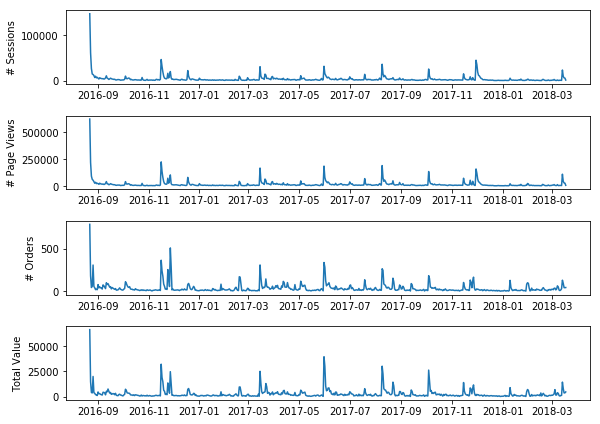

In [59]:
# Look at how key variables changed by time

x = traffic_order['date_day']

y1 = traffic_order['sessions']
y2 = traffic_order['page_views']
y3 = traffic_order['order_count']
y4 = traffic_order['total_value']

fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (8,6))
fig.tight_layout()

plt.subplot(4, 1, 1)
plt.plot(x, y1)
plt.ylabel('# Sessions')

plt.subplot(4, 1, 2)
plt.plot(x, y2)
plt.ylabel('# Page Views')

plt.subplot(4, 1, 3)
plt.plot(x, y3)
plt.ylabel('# Orders')

plt.subplot(4, 1, 4)
plt.plot(x, y4)
plt.ylabel('Total Value')

plt.show()

# The 4 variables followed a very similar pattern

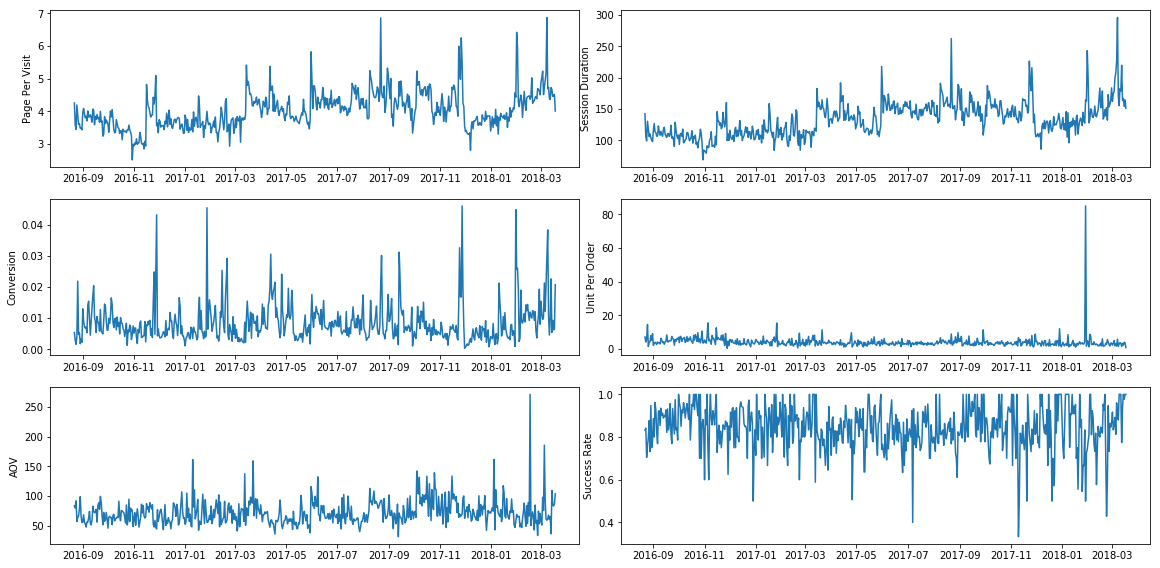

In [60]:
# Look at how KPIs changed over time

x = traffic_order['date_day']

y1 = traffic_order['page_per_session']
y2 = traffic_order['avg_session_duration']
y3 = traffic_order['conversion']
y4 = traffic_order['unit_per_order']
y5 = traffic_order['avg_order_value']
y6 = traffic_order['success_rate']

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (16,8))
fig.tight_layout()

plt.subplot(3, 2, 1)
plt.plot(x, y1)
plt.ylabel('Page Per Visit')

plt.subplot(3, 2, 2)
plt.plot(x, y2)
plt.ylabel('Session Duration')

plt.subplot(3, 2, 3)
plt.plot(x, y3)
plt.ylabel('Conversion')

plt.subplot(3, 2, 4)
plt.plot(x, y4)
plt.ylabel('Unit Per Order')

plt.subplot(3, 2, 5)
plt.plot(x, y5)
plt.ylabel('AOV')

plt.subplot(3, 2, 6)
plt.plot(x, y6)
plt.ylabel('Success Rate')

plt.show()

We see that Page Per Visit & Session Duration were slightly rising while fluctuating; Other 4 KPIs were fluctuating around a relatively steady level. This result is consistent with the high correlation between traffics & orders.

### Run Linear Regression & Check Significance

In [61]:
good_month_idx = [3,5,6,8,11]
traffic_order['good_month'] = 0
traffic_order['time'] = traffic_order.index

for i in traffic_order.index:
    month_ = traffic_order.loc[i,'date_day'].month
    day_   = traffic_order.loc[i,'date_day'].day
    if month_ in good_month_idx:
        if month_ != 5 and month_ != 6:
            traffic_order.loc[i,'good_month'] = 1
        elif month_ == 5 and day_ >= 16:
            traffic_order.loc[i,'good_month'] = 1
        elif month_ == 6 and day_ <= 15:
            traffic_order.loc[i,'good_month'] = 1

traffic_order[['time','good_month']].head()

,time,good_month
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [62]:
import statsmodels.api as sm
from scipy import stats

Y = traffic_order['order_count']
X = traffic_order[['sessions','good_month','time']]
X = sm.add_constant(X)

print(X.shape, Y.shape)

(573, 4) (573,)


In [63]:
order_session_linear = sm.OLS(Y, X).fit()
print(order_session_linear.summary())

# As expected, the relationship between order & session, order & good month are both significant
# Note that effect of good month is much bigger than number of sessions

                            OLS Regression Results                            
Dep. Variable:            order_count   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     285.7
Date:                Fri, 27 Sep 2019   Prob (F-statistic):          4.31e-113
Time:                        11:18:24   Log-Likelihood:                -2894.4
No. Observations:                 573   AIC:                             5797.
Df Residuals:                     569   BIC:                             5814.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.7614      3.504      3.928      0.0

## 2. Analyze Products

In [64]:
num_title = len(data_odrit['product_title'].drop_duplicates())
num_types = len(data_odrit['product_type'].drop_duplicates())
num_sku   = len(data_odrit['sku'].drop_duplicates())

print(num_title, num_types, num_sku)

233 11 1266


There were 233 out of 234 product titles, and 11 out of 29 product types involved in the order records. There must be mistakes in the original records, causing wrong key reference between order records & product list. I used product title as the ID for products.

In [65]:
product_all = data_odrit[['new_id','product_title','quantity','line_items_price','order_success',]]

product_all[:5]

,new_id,product_title,quantity,line_items_price,order_success
0,1.0,5cfd6c4e00b25e6dec5538928206b7b8,1,35.0,1
1,1.0,d57bc87aca919b4758da6974cdf607fa,1,45.0,1
2,2.0,d57bc87aca919b4758da6974cdf607fa,1,45.0,1
3,3.0,5cfd6c4e00b25e6dec5538928206b7b8,1,35.0,1
4,4.0,d57bc87aca919b4758da6974cdf607fa,1,45.0,1


### Compare Performance Of Each Title

In [66]:
productgroup = product_all.groupby('product_title').agg({'new_id': lambda x: len(x), 
                                                         'quantity': lambda x: x.sum(), 
                                                         'line_items_price': lambda x: x.sum(), 
                                                         'order_success': lambda x: x.sum()}).reset_index()
productgroup.rename(columns={'new_id': 'order_count', 
                             'line_items_price': 'total_value', 
                             'order_success': 'success_count'}, inplace=True)
productgroup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 5 columns):
product_title    233 non-null object
order_count      233 non-null float64
quantity         233 non-null int64
total_value      233 non-null float64
success_count    233 non-null int64
dtypes: float64(2), int64(2), object(1)
memory usage: 9.2+ KB


In [67]:
productgroup['avg_unit_price'] = productgroup['total_value'] / productgroup['quantity']
productgroup['unit_per_order'] = productgroup['quantity'] / productgroup['order_count']
productgroup['avg_order_value'] = productgroup['total_value'] / productgroup['order_count']
productgroup['fail_rate'] = 1 - (productgroup['success_count'] / productgroup['order_count'])

productgroup.head()

,product_title,order_count,quantity,total_value,success_count,avg_unit_price,unit_per_order,avg_order_value,fail_rate
0,0241ebc0c6649e7363413200c9f0c6c1,209.0,209,11982.8,151,57.333971,1.000000,57.333971,0.277512
1,05bfa6ae37a7e12fd22dcc33fb808520,17.0,17,1319.3,14,77.605882,1.000000,77.605882,0.176471
2,07c761f430e10809e29576e94ec86d4b,136.0,136,5695.2,100,41.876471,1.000000,41.876471,0.264706
3,07dd8ba2ccadf3f3766750f10f6d05b5,1561.0,1592,35982.5,1319,22.602073,1.019859,23.050929,0.155029
4,082381794c332c9d406c2ee4a5438d53,27.0,27,1943.4,22,71.977778,1.000000,71.977778,0.185185


In [68]:
productgroup.describe()

,order_count,quantity,total_value,success_count,avg_unit_price,unit_per_order,avg_order_value,fail_rate
count,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000
mean,158.051502,159.180258,6852.748884,124.862661,50.007630,1.010097,50.334912,0.201875
std,201.803350,204.176948,7530.647834,166.747481,17.516072,0.058817,17.482135,0.080768
min,2.000000,2.000000,70.000000,2.000000,10.000000,1.000000,17.500000,0.000000
25%,39.000000,39.000000,2205.000000,33.000000,37.779710,1.000000,37.819048,0.181518
50%,100.000000,101.000000,4358.400000,74.000000,47.902041,1.000000,47.989695,0.214815
75%,196.000000,202.000000,8332.660000,151.000000,61.173333,1.004762,61.173333,0.248588
max,1561.000000,1592.000000,49450.500000,1319.000000,107.113462,1.750000,107.113462,0.367713


Most products were purchase only once in a single order. Hence, distributions of Avg Price & AOV, Quantity & Order Counts are very close.

Need to look at quantity & fail rate to compare performance.

#### Look At Quantity & Fail Rate

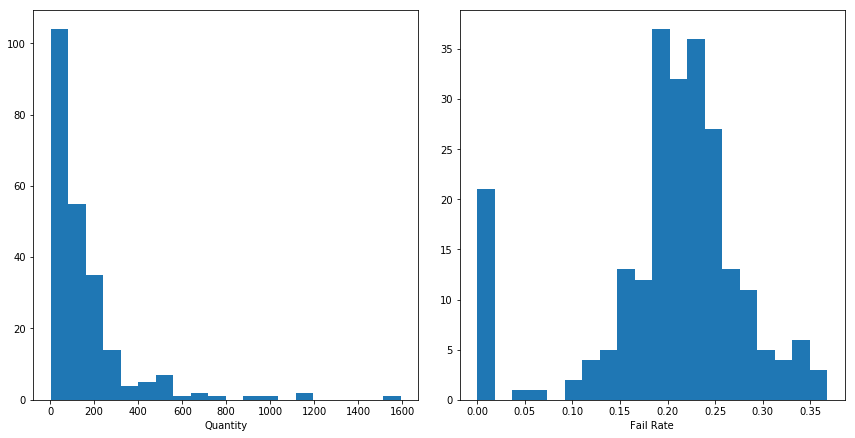

In [69]:
x1 = productgroup['quantity']
x2 = productgroup['fail_rate']

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
fig.tight_layout()

plt.subplot(1, 2, 1)
plt.hist(x1, 20)
plt.xlabel('Quantity')

plt.subplot(1, 2, 2)
plt.hist(x2, 20)
plt.xlabel('Fail Rate')

plt.show()

Quantity is distributed in a quite wide range, while around 75% products were sold less than 200 times.

Fail Rate is almost normal distributed, if ignoring the left hand section.

In [70]:
productgroup.corr()

,order_count,quantity,total_value,success_count,avg_unit_price,unit_per_order,avg_order_value,fail_rate
order_count,1.000000,0.999933,0.886961,0.998120,-0.310337,-0.039527,-0.313925,0.079007
quantity,0.999933,1.000000,0.885135,0.998277,-0.311000,-0.036028,-0.314236,0.076932
total_value,0.886961,0.885135,1.000000,0.880146,-0.066944,-0.059981,-0.070228,0.107569
success_count,0.998120,0.998277,0.880146,1.000000,-0.300312,-0.034910,-0.303434,0.047347
avg_unit_price,-0.310337,-0.311000,-0.066944,-0.300312,1.000000,-0.173191,0.996527,-0.219809
unit_per_order,-0.039527,-0.036028,-0.059981,-0.034910,-0.173191,1.000000,-0.108108,-0.221431
avg_order_value,-0.313925,-0.314236,-0.070228,-0.303434,0.996527,-0.108108,1.000000,-0.236409
fail_rate,0.079007,0.076932,0.107569,0.047347,-0.219809,-0.221431,-0.236409,1.000000


We see that quantity is weakly negatively correlated to price, and fail rate is weakly negatively correlated to price and unit per order. But there no obvious correlation between quantity & fail rate.

In [71]:
productgroup = productgroup.sort_values(['quantity'], ascending = False)

top50_sale = list(productgroup['product_title'][:50])

In [72]:
productgroup = productgroup.sort_values(['fail_rate'], ascending = False)

top50_fail = list(productgroup['product_title'][:50])

In [73]:
list(set(top50_fail)&set(top50_sale))
# Only 7 products rank top 50 for both fail rate & quantity

['5b8ecd13afb8fefce84a4735e2f01eb0',
 '287abfa2b9c3c246dc7337869c3f8a4c',
 'cc78914da41ed73deea3b409e307b11d',
 'fb337868ffefe5e008e8dc6d6a4f283a',
 'a350494c0033885ce70b64d3c5765e22',
 '08bbf9d4710e8bdbfd07c763ecb2f9e3',
 '2db8af033406b6667239b4f8beea9b46']

### Relationship Between Products

In [74]:
product_suc = product_all[product_all['order_success'] == 1]
product_suc = product_suc[['new_id','product_title','quantity']]

product_suc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29093 entries, 0 to 36825
Data columns (total 3 columns):
new_id           29093 non-null float64
product_title    29093 non-null object
quantity         29093 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 909.2+ KB


In [75]:
product_quant = pd.get_dummies(product_suc['product_title'])
product_quant = pd.concat([product_suc, product_quant], axis = 1)
product_quant.head()

,new_id,product_title,quantity,0241ebc0c6649e7363413200c9f0c6c1,05bfa6ae37a7e12fd22dcc33fb808520,07c761f430e10809e29576e94ec86d4b,07dd8ba2ccadf3f3766750f10f6d05b5,082381794c332c9d406c2ee4a5438d53,08bbf9d4710e8bdbfd07c763ecb2f9e3,092ec4ed8be6836505be97a003891f4f,...,f6870e4a1d7a5a58cc2cf876d1f960c5,f8a70eddaf017cac3768032915bec9ed,f8bfd531c69017fdbef27e55654cfcbb,f920f0d83b20efc9c4d918290a9ce7c4,fb337868ffefe5e008e8dc6d6a4f283a,fba9971d431a222913bfc5fbd68c5126,fd3030ca110c77ac004d3dfefb8c3152,fdc3f892b388f8ae4d2cd41ab8220dfb,fe8aa78e482a59c17b9aa2de3942656a,ff4c94a4f9dfa83e85297ce453cb6034
0,1.0,5cfd6c4e00b25e6dec5538928206b7b8,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,d57bc87aca919b4758da6974cdf607fa,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,d57bc87aca919b4758da6974cdf607fa,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,5cfd6c4e00b25e6dec5538928206b7b8,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.0,d57bc87aca919b4758da6974cdf607fa,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
title_list = list(product_quant.columns)
title_list.remove('new_id')
title_list.remove('product_title')
title_list.remove('quantity')

len(title_list)

233

In [77]:
for title in title_list:
    product_quant[title] = product_quant[title] * product_quant['quantity']
    
product_quant.head()

,new_id,product_title,quantity,0241ebc0c6649e7363413200c9f0c6c1,05bfa6ae37a7e12fd22dcc33fb808520,07c761f430e10809e29576e94ec86d4b,07dd8ba2ccadf3f3766750f10f6d05b5,082381794c332c9d406c2ee4a5438d53,08bbf9d4710e8bdbfd07c763ecb2f9e3,092ec4ed8be6836505be97a003891f4f,...,f6870e4a1d7a5a58cc2cf876d1f960c5,f8a70eddaf017cac3768032915bec9ed,f8bfd531c69017fdbef27e55654cfcbb,f920f0d83b20efc9c4d918290a9ce7c4,fb337868ffefe5e008e8dc6d6a4f283a,fba9971d431a222913bfc5fbd68c5126,fd3030ca110c77ac004d3dfefb8c3152,fdc3f892b388f8ae4d2cd41ab8220dfb,fe8aa78e482a59c17b9aa2de3942656a,ff4c94a4f9dfa83e85297ce453cb6034
0,1.0,5cfd6c4e00b25e6dec5538928206b7b8,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,d57bc87aca919b4758da6974cdf607fa,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,d57bc87aca919b4758da6974cdf607fa,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,5cfd6c4e00b25e6dec5538928206b7b8,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.0,d57bc87aca919b4758da6974cdf607fa,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
temp1 = product_quant.groupby('new_id')['product_title'].count()
temp1 = pd.DataFrame(temp1)
temp2 = product_quant.drop(['product_title'], axis = 'columns')
temp3 = temp2.groupby('new_id').sum()

prodgroup_quant = temp1.merge(temp3, on = 'new_id')

prodgroup_quant[:5]

,product_title,quantity,0241ebc0c6649e7363413200c9f0c6c1,05bfa6ae37a7e12fd22dcc33fb808520,07c761f430e10809e29576e94ec86d4b,07dd8ba2ccadf3f3766750f10f6d05b5,082381794c332c9d406c2ee4a5438d53,08bbf9d4710e8bdbfd07c763ecb2f9e3,092ec4ed8be6836505be97a003891f4f,0a791b5dc0e7431cc1bc8d05ad9d439b,...,f6870e4a1d7a5a58cc2cf876d1f960c5,f8a70eddaf017cac3768032915bec9ed,f8bfd531c69017fdbef27e55654cfcbb,f920f0d83b20efc9c4d918290a9ce7c4,fb337868ffefe5e008e8dc6d6a4f283a,fba9971d431a222913bfc5fbd68c5126,fd3030ca110c77ac004d3dfefb8c3152,fdc3f892b388f8ae4d2cd41ab8220dfb,fe8aa78e482a59c17b9aa2de3942656a,ff4c94a4f9dfa83e85297ce453cb6034
new_id,,,,,,,,,,,,,,,,,,,,,
1.0,2,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5.0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
prodgroup_quant[['product_title','quantity']].describe()

,product_title,quantity
count,17846.000000,17846.000000
mean,1.630225,1.642105
std,1.795122,1.806764
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,132.000000,132.000000


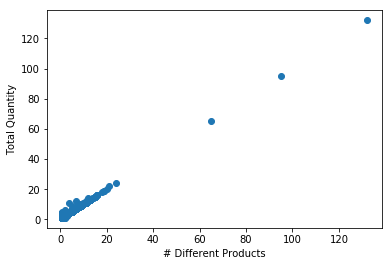

In [80]:
x = prodgroup_quant['product_title']
y = prodgroup_quant['quantity']

plt.scatter(x, y)
plt.xlabel('# Different Products')
plt.ylabel('Total Quantity')
plt.show()

Number of Different Products & Total Quantity are the same in most orders, but not always consistent.

In many orders, only one product was purchased, while there were also at least 75% orders with 2 or more products.

#### Correlation Between Products

In [81]:
title_corr = prodgroup_quant[title_list].corr()

title_corr.head()

,0241ebc0c6649e7363413200c9f0c6c1,05bfa6ae37a7e12fd22dcc33fb808520,07c761f430e10809e29576e94ec86d4b,07dd8ba2ccadf3f3766750f10f6d05b5,082381794c332c9d406c2ee4a5438d53,08bbf9d4710e8bdbfd07c763ecb2f9e3,092ec4ed8be6836505be97a003891f4f,0a791b5dc0e7431cc1bc8d05ad9d439b,0b887ac0ac64eaef0dc99575a02e20ff,0c3096ae56e871c8bbef12a8d8b63aae,...,f6870e4a1d7a5a58cc2cf876d1f960c5,f8a70eddaf017cac3768032915bec9ed,f8bfd531c69017fdbef27e55654cfcbb,f920f0d83b20efc9c4d918290a9ce7c4,fb337868ffefe5e008e8dc6d6a4f283a,fba9971d431a222913bfc5fbd68c5126,fd3030ca110c77ac004d3dfefb8c3152,fdc3f892b388f8ae4d2cd41ab8220dfb,fe8aa78e482a59c17b9aa2de3942656a,ff4c94a4f9dfa83e85297ce453cb6034
0241ebc0c6649e7363413200c9f0c6c1,1.000000,-0.002538,0.031532,-0.021214,-0.003182,-0.008026,0.014773,-0.003662,-0.007554,0.021668,...,0.021888,-0.002362,-0.004129,0.032088,-0.002513,-0.000959,-0.002035,-0.003393,-0.016302,0.032401
05bfa6ae37a7e12fd22dcc33fb808520,-0.002538,1.000000,-0.001987,-0.007194,-0.000984,-0.002483,-0.001590,-0.001133,-0.002337,-0.001244,...,-0.002324,-0.002657,-0.001277,-0.003118,-0.002699,-0.000297,-0.000629,0.052461,-0.005043,-0.001684
07c761f430e10809e29576e94ec86d4b,0.031532,-0.001987,1.000000,-0.018207,-0.002491,-0.006283,-0.004023,-0.002867,-0.005914,-0.003148,...,-0.005881,0.000638,-0.003232,-0.007891,0.000513,-0.000751,-0.001593,-0.002656,-0.012762,0.006922
07dd8ba2ccadf3f3766750f10f6d05b5,-0.021214,-0.007194,-0.018207,1.000000,-0.009021,0.000799,-0.011397,-0.010380,-0.003793,-0.011399,...,-0.019425,-0.020387,-0.011703,0.006654,-0.008916,-0.002718,-0.005767,-0.009617,0.009530,-0.015431
082381794c332c9d406c2ee4a5438d53,-0.003182,-0.000984,-0.002491,-0.009021,1.000000,-0.003113,-0.001993,-0.001420,-0.002930,-0.001560,...,0.012740,-0.003332,-0.001601,-0.003909,-0.003384,-0.000372,-0.000789,-0.001316,-0.006323,-0.002111


In [82]:
high_corr = []
mode_corr = []
weak_corr = []

max_corr = 0

for r in title_list:
    for c in title_list:
        if r != c:
            corr = title_corr.loc[r, c]
            if abs(corr) >= 0.7 and (c, r, corr) not in high_corr:
                high_corr.append((r, c, corr))
            elif abs(corr) >= 0.4 and (c, r, corr) not in mode_corr:
                mode_corr.append((r, c, corr))
            elif abs(corr) >= 0.1 and (c, r, corr) not in weak_corr:
                weak_corr.append((r, c, corr))
            if abs(corr) > abs(max_corr):
                max_corr = corr

print(len(high_corr), len(mode_corr), len(weak_corr), max_corr)

0 3 200 0.4209860267477155


In [83]:
len(title_list) * (len(title_list) - 1) / 2

27028.0

Out of 27028 possible product pairs, no pair has high correlation (above 0.7 in magnitude), only 3 pairs have moderate correlation (between 0.4 and 0.7 in magnitude), and 200 pairs have weak correlation (between 0.1 and 0.4 in magnitude). Note that the strongest correlation is around 0.42, which is just above the moderate threshold.

#### Market Basket Analysis

In [84]:
product_dummy = pd.get_dummies(product_suc['product_title'])
product_dummy = pd.concat([product_suc, product_dummy], axis = 1)
product_dummy = product_dummy.drop(['product_title','quantity'], axis = 'columns')

product_dummy.head()

,new_id,0241ebc0c6649e7363413200c9f0c6c1,05bfa6ae37a7e12fd22dcc33fb808520,07c761f430e10809e29576e94ec86d4b,07dd8ba2ccadf3f3766750f10f6d05b5,082381794c332c9d406c2ee4a5438d53,08bbf9d4710e8bdbfd07c763ecb2f9e3,092ec4ed8be6836505be97a003891f4f,0a791b5dc0e7431cc1bc8d05ad9d439b,0b887ac0ac64eaef0dc99575a02e20ff,...,f6870e4a1d7a5a58cc2cf876d1f960c5,f8a70eddaf017cac3768032915bec9ed,f8bfd531c69017fdbef27e55654cfcbb,f920f0d83b20efc9c4d918290a9ce7c4,fb337868ffefe5e008e8dc6d6a4f283a,fba9971d431a222913bfc5fbd68c5126,fd3030ca110c77ac004d3dfefb8c3152,fdc3f892b388f8ae4d2cd41ab8220dfb,fe8aa78e482a59c17b9aa2de3942656a,ff4c94a4f9dfa83e85297ce453cb6034
0,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
prodgroup_dummy = product_dummy.groupby('new_id').max()

prodgroup_dummy.head()

,0241ebc0c6649e7363413200c9f0c6c1,05bfa6ae37a7e12fd22dcc33fb808520,07c761f430e10809e29576e94ec86d4b,07dd8ba2ccadf3f3766750f10f6d05b5,082381794c332c9d406c2ee4a5438d53,08bbf9d4710e8bdbfd07c763ecb2f9e3,092ec4ed8be6836505be97a003891f4f,0a791b5dc0e7431cc1bc8d05ad9d439b,0b887ac0ac64eaef0dc99575a02e20ff,0c3096ae56e871c8bbef12a8d8b63aae,...,f6870e4a1d7a5a58cc2cf876d1f960c5,f8a70eddaf017cac3768032915bec9ed,f8bfd531c69017fdbef27e55654cfcbb,f920f0d83b20efc9c4d918290a9ce7c4,fb337868ffefe5e008e8dc6d6a4f283a,fba9971d431a222913bfc5fbd68c5126,fd3030ca110c77ac004d3dfefb8c3152,fdc3f892b388f8ae4d2cd41ab8220dfb,fe8aa78e482a59c17b9aa2de3942656a,ff4c94a4f9dfa83e85297ce453cb6034
new_id,,,,,,,,,,,,,,,,,,,,,
1.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
prodgroup_dummy.shape

(17846, 233)

In [88]:
from sklearn.linear_model import LogisticRegression

column_list = list(prodgroup_dummy.columns)

high_positive = []
mode_positive = [] 
high_negative = []
mode_negative = []

for target in column_list:
    idx = column_list.index(target)
    
    Y = prodgroup_dummy[target]
    temp = list(prodgroup_dummy.columns)
    temp.remove(target)
    X = prodgroup_dummy[temp]

    logist = LogisticRegression().fit(X, Y)
    result = logist.coef_
    effect = np.exp(result) - 1
    mareff = []
    for item in effect:
        for number in item:
            mareff.append(number)
    
    for i in range(len(mareff)):
        if i < idx:
            regres = column_list[i]
        else:
            regres = column_list[i+1]
            
        eff = mareff[i]
        if eff > 0:
            if eff >= 0.9:
                high_positive.append((target, regres, eff))
            elif eff >= 0.5:
                mode_positive.append((target, regres, eff))
        elif eff < 0:
            if eff <= 0.9:
                high_negative.append((target, regres, eff))
            elif eff <= 0.5:
                mode_negative.append((target, regres, eff))

print(len(high_positive),len(mode_positive),len(high_negative),len(mode_negative))

C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\STU\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

3020 2425 43440 0


Market Basket Analysis implies that there 3020  & 2425 pairs of products with strong and moderate positive relationship, respectively, and around 43,000 pairs of products with moderate negatvie relationship. This is consistent with results above that most orders only have one product purchased.

This result could be helpful in designing recommendations, and bundles.

## 3. How Promotion Affects Sales

In [89]:
data_order['disc_flag'] = 0

for i in list(data_order.index):
    if data_order.loc[i, 'total_discounts'] != 0:
        data_order.loc[i, 'disc_flag'] = 1

data_order['disc_flag'].head()

0    0
1    0
2    0
3    0
4    0
Name: disc_flag, dtype: int64

In [90]:
data_order['disc_flag'].sum() / len(data_order['disc_flag'])
# There were 37.46% orders with discount

0.3745669070137653

In [91]:
data_order[['total_discounts','total_line_items_price','subtotal_price','order_success']].corr()

,total_discounts,total_line_items_price,subtotal_price,order_success
total_discounts,1.000000,0.703178,-0.072155,0.024097
total_line_items_price,0.703178,1.000000,0.657389,-0.134787
subtotal_price,-0.072155,0.657389,1.000000,-0.214138
order_success,0.024097,-0.134787,-0.214138,1.000000


It is seen that discounts are strongly correlated to line item price, which is moderately correlated to subtotal price. But correlation between discount and subtotal price is very weak. However, the causal relationship between discounts and sales is not clear.

In [92]:
data_order[['total_discounts','total_line_items_price','subtotal_price','order_success']].describe()

,total_discounts,total_line_items_price,subtotal_price,order_success
count,21358.000000,21358.000000,21358.000000,21358.000000
mean,8.576576,74.751685,66.541506,0.835565
std,60.638845,80.223325,56.956924,0.370678
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.000000,32.000000,1.000000
50%,0.000000,58.000000,52.000000,1.000000
75%,7.000000,94.000000,86.000000,1.000000
max,5616.000000,5616.000000,997.800000,1.000000


In [93]:
disc_group = data_order.groupby('disc_flag')['total_line_items_price'].mean()
disc_group

disc_flag
0    73.812726
1    76.319513
Name: total_line_items_price, dtype: float64

Divided into 2 groups, there's no big difference on line item price between orders with & without discount.

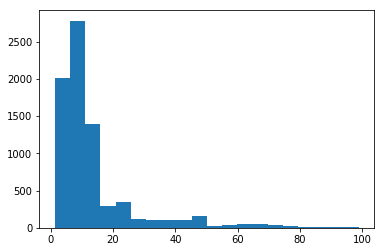

In [94]:
label = data_order[(data_order['total_discounts'] > 0) & (data_order['total_discounts'] < 100)]['total_discounts']

plt.hist(label, 20)
plt.show()

In [95]:
data_order['disc_level'] = 0

for i in list(data_order.index):
    disc = data_order.loc[i, 'total_discounts']
    if disc >= 100:
        data_order.loc[i, 'disc_level'] = 5
    elif disc >= 20:
        data_order.loc[i, 'disc_level'] = 4
    elif disc >= 10:
        data_order.loc[i, 'disc_level'] = 3
    elif disc >= 5:
        data_order.loc[i, 'disc_level'] = 2
    elif disc >= 0:
        data_order.loc[i, 'disc_level'] = 1

data_order['disc_flag'].head()

0    0
1    0
2    0
3    0
4    0
Name: disc_flag, dtype: int64

In [96]:
disc_group = data_order.groupby('disc_level')['total_line_items_price'].mean()
disc_group

disc_level
1     70.380962
2     58.623486
3     77.493486
4    107.790513
5    259.197020
Name: total_line_items_price, dtype: float64

Dividing discounts into several leveals, we see obvious differences among groups.

In [97]:
X = data_order[['total_discounts','subtotal_price','shipping_rate']]
Y = data_order['total_price']
X = sm.add_constant(X)

print(X.shape, Y.shape)

(21358, 4) (21358,)


In [98]:
sales_discounts_linear = sm.OLS(Y, X).fit()
print(sales_discounts_linear.summary())

                            OLS Regression Results                            
Dep. Variable:            total_price   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.185e+06
Date:                Fri, 27 Sep 2019   Prob (F-statistic):               0.00
Time:                        11:33:50   Log-Likelihood:                -62573.
No. Observations:               21358   AIC:                         1.252e+05
Df Residuals:                   21354   BIC:                         1.252e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.3434      0.059     

Though strongly correlated to line item price, discounts turned out to have significant negative relationship with total price. This counld imply that discounts were not promoting sales. Note that estimated coefficient of discount is actually very small in magnitude, so it could also be that discount is just a little bit higher than optimal level, while it is stimulating sales. Hence, it'd be better to have an experiment to be sure.

### Effects Of Discounts Based On Customers

In [99]:
data_order['order_date2'] = data_order['order_date']

cust_group = data_order.groupby('cust_id').agg({'new_id': lambda x: len(x),
                                                'order_date': lambda x: x.min(), 
                                                'order_date2': lambda x: x.max(),
                                                'subtotal_price': lambda x: x.sum(),
                                                'total_discounts': lambda x: x.sum(),
                                                'shipping_rate': lambda x: x.sum()}).reset_index()

cust_group.rename(columns={'new_id': 'order_count', 
                           'order_date': 'first_date',
                           'order_date2': 'last_date'}, inplace=True)

cust_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 7 columns):
cust_id            4998 non-null float64
order_count        4998 non-null float64
first_date         4998 non-null datetime64[ns]
last_date          4998 non-null datetime64[ns]
subtotal_price     4998 non-null float64
total_discounts    4998 non-null float64
shipping_rate      4998 non-null float64
dtypes: datetime64[ns](2), float64(5)
memory usage: 273.4 KB


In [100]:
cust_group[:5]

,cust_id,order_count,first_date,last_date,subtotal_price,total_discounts,shipping_rate
0,8.683755e+09,10.0,2016-08-21,2017-03-30,766.5,190.5,48.33
1,8.686225e+09,10.0,2016-08-22,2017-01-31,237.0,1157.0,28.00
2,8.686914e+09,3.0,2016-11-17,2017-06-02,110.0,5.0,21.00
3,8.686916e+09,1.0,2016-08-22,2016-08-22,120.0,0.0,0.00
4,8.686924e+09,1.0,2016-08-22,2016-08-22,77.0,0.0,7.00


In [101]:
cust_disc = cust_group[cust_group['total_discounts'] != 0]
print(len(cust_disc.index), len(cust_disc.index) / len(cust_group.index))
# 32.31% of customers has enjoyed discounts

1615 0.3231292517006803


In [102]:
cust_group['low_freq'] = 0
cust_group['duration'] = 0
cust_group['ipt'] = 0

for i in range(len(cust_group.index)):
    cust_group.loc[i, 'duration'] = (cust_group.loc[i, 'last_date'] - cust_group.loc[i, 'first_date']).days
    if cust_group.loc[i, 'order_count'] == 1:
        cust_group.loc[i, 'low_freq'] = 1
        cust_group.loc[i, 'ipt'] = 0
    else:
        cust_group.loc[i, 'ipt'] = cust_group.loc[i, 'duration'] / (cust_group.loc[i, 'order_count'] - 1)

cust_group['aov'] = cust_group['subtotal_price'] / cust_group['order_count']
cust_group['sale_disc_ratio'] = cust_group['subtotal_price'] / cust_group['total_discounts']

cust_group.head()

,cust_id,order_count,first_date,last_date,subtotal_price,total_discounts,shipping_rate,low_freq,duration,ipt,aov,sale_disc_ratio
0,8.683755e+09,10.0,2016-08-21,2017-03-30,766.5,190.5,48.33,0,221,24.555556,76.650000,4.023622
1,8.686225e+09,10.0,2016-08-22,2017-01-31,237.0,1157.0,28.00,0,162,18.000000,23.700000,0.204840
2,8.686914e+09,3.0,2016-11-17,2017-06-02,110.0,5.0,21.00,0,197,98.500000,36.666667,22.000000
3,8.686916e+09,1.0,2016-08-22,2016-08-22,120.0,0.0,0.00,1,0,0.000000,120.000000,inf
4,8.686924e+09,1.0,2016-08-22,2016-08-22,77.0,0.0,7.00,1,0,0.000000,77.000000,inf


In [103]:
cust_group = cust_group.merge(df_cust, how = 'inner', on = 'cust_id')

cust_group['cust_date'] = pd.to_datetime(cust_group['cust_date'])
cust_group.head()

,cust_id,order_count,first_date,last_date,subtotal_price,total_discounts,shipping_rate,low_freq,duration,ipt,aov,sale_disc_ratio,full_name,cust_date
0,8.683755e+09,10.0,2016-08-21,2017-03-30,766.5,190.5,48.33,0,221,24.555556,76.650000,4.023622,Donna Pierce,2016-08-21
1,8.686225e+09,10.0,2016-08-22,2017-01-31,237.0,1157.0,28.00,0,162,18.000000,23.700000,0.204840,Ashley Montgomery,2016-08-22
2,8.686914e+09,3.0,2016-11-17,2017-06-02,110.0,5.0,21.00,0,197,98.500000,36.666667,22.000000,Timothy Johnson,2016-08-22
3,8.686916e+09,1.0,2016-08-22,2016-08-22,120.0,0.0,0.00,1,0,0.000000,120.000000,inf,Michael Ellis,2016-08-22
4,8.686924e+09,1.0,2016-08-22,2016-08-22,77.0,0.0,7.00,1,0,0.000000,77.000000,inf,Brad Miller,2016-08-22


In [104]:
cust_group['days_before'] = 0

for i in range(len(cust_group.index)):
    cust_group.loc[i, 'days_before'] = (cust_group.loc[i, 'first_date'] - cust_group.loc[i, 'cust_date']).days

cust_group['days_before'].min()

-3

In [105]:
Y = cust_group['subtotal_price']
X = cust_group[['total_discounts','ipt','days_before','order_count','shipping_rate','low_freq']]
X = sm.add_constant(X)

cust_discounts_linear = sm.OLS(Y, X).fit()
print(cust_discounts_linear.summary())

                            OLS Regression Results                            
Dep. Variable:         subtotal_price   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 6.445e+04
Date:                Fri, 27 Sep 2019   Prob (F-statistic):               0.00
Time:                        11:36:19   Log-Likelihood:                -27624.
No. Observations:                4379   AIC:                         5.526e+04
Df Residuals:                    4372   BIC:                         5.531e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              15.6452      5.413     

The IPT, Order Count, Shipping Rate, and Low Frequency Flag have significant effects on Subtotal Price. Among the 4 varialbes, only Order Count has positive effect. Effect of discount is not significant at all. Order Count has the biggest effect on total sales, which is as expected.

In [106]:
Y = cust_group['aov']

cust_discounts_linear = sm.OLS(Y, X).fit()
print(cust_discounts_linear.summary())

                            OLS Regression Results                            
Dep. Variable:                    aov   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.885
Date:                Fri, 27 Sep 2019   Prob (F-statistic):           5.52e-05
Time:                        11:38:30   Log-Likelihood:                -22795.
No. Observations:                4379   AIC:                         4.560e+04
Df Residuals:                    4372   BIC:                         4.565e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              72.1897      1.797     

Targeting at Average Order Value, all variables have significant effects, except for discount. Note that Order Count still has very big effect in magnitude on sales per order. 

In [107]:
cust_disc = cust_group[cust_group['total_discounts'] != 0]

D_bar = cust_disc['total_discounts'].mean()
S_bar = cust_disc['aov'].mean()

disc_sensitivity = (0.0037 * D_bar) / S_bar
disc_sensitivity

0.0025737085289439404

In [108]:
cust_nods = cust_group[cust_group['total_discounts'] == 0]

print(S_bar, cust_nods['aov'].mean())

60.064386661559034 68.44974779488494


Discount Sensitivity is less than 1, and very close to 0. The mean AOV among no-discount customers is even a little bit higher than that of customers with discounts. This implies that, overall, customers are not sensitivie or encouraged by discounts. This is also consistent with the regression results above.

## 4. Suggestion For Growth Of Sales

### Look For Valuable Customers

In [117]:
cust_sort = cust_group[['cust_id','subtotal_price','order_count','duration',
                        'ipt','days_before','aov','full_name']].sort_values('subtotal_price', ascending = False).reset_index()

total_sales = cust_sort['subtotal_price'].sum()
total_cust  = len(cust_sort.index)
avg_sales   = total_sales / total_cust

print(total_sales, total_cust, avg_sales)

741707.3200000001 4379 169.378241607673


In [118]:
cust_sort['sales%'] = cust_sort['subtotal_price'] / total_sales
cust_sort['accu_sales%'] = 0

current_accu = 0

for i in range(len(cust_sort.index)):
    percent = cust_sort.loc[i, 'sales%']
    cust_sort.loc[i, 'accu_sales%'] = percent + current_accu
    current_accu += percent

print(current_accu, cust_sort['accu_sales%'].max())

0.9999999999999999 0.9999999999999999


In [121]:
top80_cust = len(cust_sort[cust_sort['accu_sales%'] <= 0.8].index)

print(top80_cust, top80_cust / total_cust)

1532 0.34985156428408315


The top 35% of customers contributed to 80% of total sales.

In [126]:
cust_sort['valuable'] = 0

for i in range(len(cust_sort.index)):
    if cust_sort.loc[i, 'accu_sales%'] <= 0.8:
        cust_sort.loc[i, 'valuable'] = 1

valuable_group = cust_sort.groupby('valuable')['subtotal_price','order_count','duration','ipt','days_before','aov'].mean()
valuable_group

,subtotal_price,order_count,duration,ipt,days_before,aov
valuable,,,,,,
0,52.131085,1.174570,25.682122,23.182239,59.759045,46.513823
1,387.265091,4.705614,169.710183,82.450892,40.127285,103.478286


Valuable customers tend to have higher average AOV, Order Count, Duration, Inter Purchase Time, and make first order sooner after registration than common customers. Note that in the regression results above, IPT is associated to decrease in sales, which does not match the result here. The reason might be that many common customers made only one order in the whole period, and their IPT is 0, thus making the average IPT much smaller.

### Look At Processing Speed

In [128]:
data_order['process_date'] = pd.to_datetime(data_order['process_date'])
data_order['process_days'] = 0

for i in range(len(data_order.index)):
    data_order.loc[i, 'process_days'] = (data_order.loc[i, 'process_date'] - data_order.loc[i, 'order_date']).days

data_order['process_days'].describe()

count    21358.000000
mean        -0.000328
std          0.024670
min         -2.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.000000
Name: process_days, dtype: float64

In [131]:
speed_group = data_order.groupby('process_days')['new_id'].count()
speed_group

process_days
-2        3
-1        1
 0    21354
Name: new_id, dtype: int64

All the orders, except for 4, were processed on the same day of order placement. Hence, processing speed might not be relevant to the variance of sales.

### Conclusions

1.	Improve website design & visitor experience, to increase web traffic. The focus needs to be placed on the good months: March, August, November, Late May, and Early June. Those periods are when people buy much more than usual.

2.	Increase exposures of the top products in unit sales to customers. Look at products with top fail rate and figure out whether the order failed because of the products themselves and why. Could analyze customer reviews and conduct customer surveys to solve the issue.

3.	Building recommendations & product bundles based on product correlations & results of Market Basket Analysis. Need to avoid product pairs with negative relationships.

4.	Decrease the amounts of overall discounts, since customers are not encouraged by it. Could conduct further experiment to figure out whether discounts have different effects on different customer groups or time periods.

5.	Focus the marketing budgets on valuable customers. Encourage them to buy more frequently, offer better shipping options to reduce the shipping rate. 

6.	Send reminders and conduct surveys for common customers, especially those with only one order, to figure out why they are unsatisfied with the store.

7.	Build predictive models to detect potential valuable customers out of new registered users or guests, using their behavior data & demographic information. Encourage the potential valuable customers to make their first order soon after registration.

Could try churn rate.